# FED3 Analysis Pipeline

This notebook demonstrates a reusable workflow for loading FED3 sample sessions, running quality checks, and generating FR1 analyses.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts.preprocessing import build_session_catalog, session_cache, motor_turn_summary
from scripts.accuracy import read_and_record, plot_cumulative_accuracy, graph_group_stats
from scripts.intervals import perform_T_test
from scripts.meals import process_meal_data, find_meals_paper
from scripts.direction_transition import (
    split_data_to_blocks,
    get_transition_info,
    first_meal_stats,
    learning_result,
    learning_score,
    plot_learning_score_trend,
    plot_pellet_ratio_trend,
    plot_transition_stats,
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
SAMPLE_ROOT = Path("sample_data")
GROUP_MAP_PATH = Path("group_map.json")
FIGURE_ROOT = Path("figures")
FIGURE_ROOT.mkdir(exist_ok=True)

session_cache.cache_clear()
SESSIONS, GROUPINGS = build_session_catalog(SAMPLE_ROOT, GROUP_MAP_PATH)
GROUP_NAMES = list(GROUPINGS.keys())
GROUP_SESSIONS = {
    group: {stype: [key.session_id for key in mapping] for stype, mapping in session_types.items()}
    for group, session_types in GROUPINGS.items()
}
GROUPS = list(GROUP_SESSIONS.keys())
TEST_PAIRS = [(GROUPS[0], GROUPS[1])] if len(GROUPS) >= 2 else []

In [3]:
dispense_rows = []
for session in SESSIONS.values():
    cnt, prop = motor_turn_summary(session.key.session_path)
    dispense_rows.append(
        {
            "session_id": session.key.session_id,
            "mouse_id": session.key.mouse_id,
            "group": session.key.group,
            "session_type": session.key.session_type,
            "exceeding_cnt": cnt,
            "proportion": prop,
        }
    )
dispense_df = (
    pd.DataFrame(dispense_rows)
    .sort_values(["group", "mouse_id", "session_id"])
    .reset_index(drop=True)
)
removed_sessions = dispense_df[dispense_df["proportion"] > 0.2]
print("Dispense quality summary:")
print(removed_sessions)

for idx, row in removed_sessions.iterrows():
    _ = SESSIONS.pop(row['session_id'])
    GROUP_SESSIONS[row['group']][row['session_type']].remove(row['session_id'])

Dispense quality summary:
    session_id mouse_id   group session_type  exceeding_cnt  proportion
117    M68_fr1      M68  female          FR1             34    0.314815
129    M74_fr1      M74  female          FR1             16    0.533333


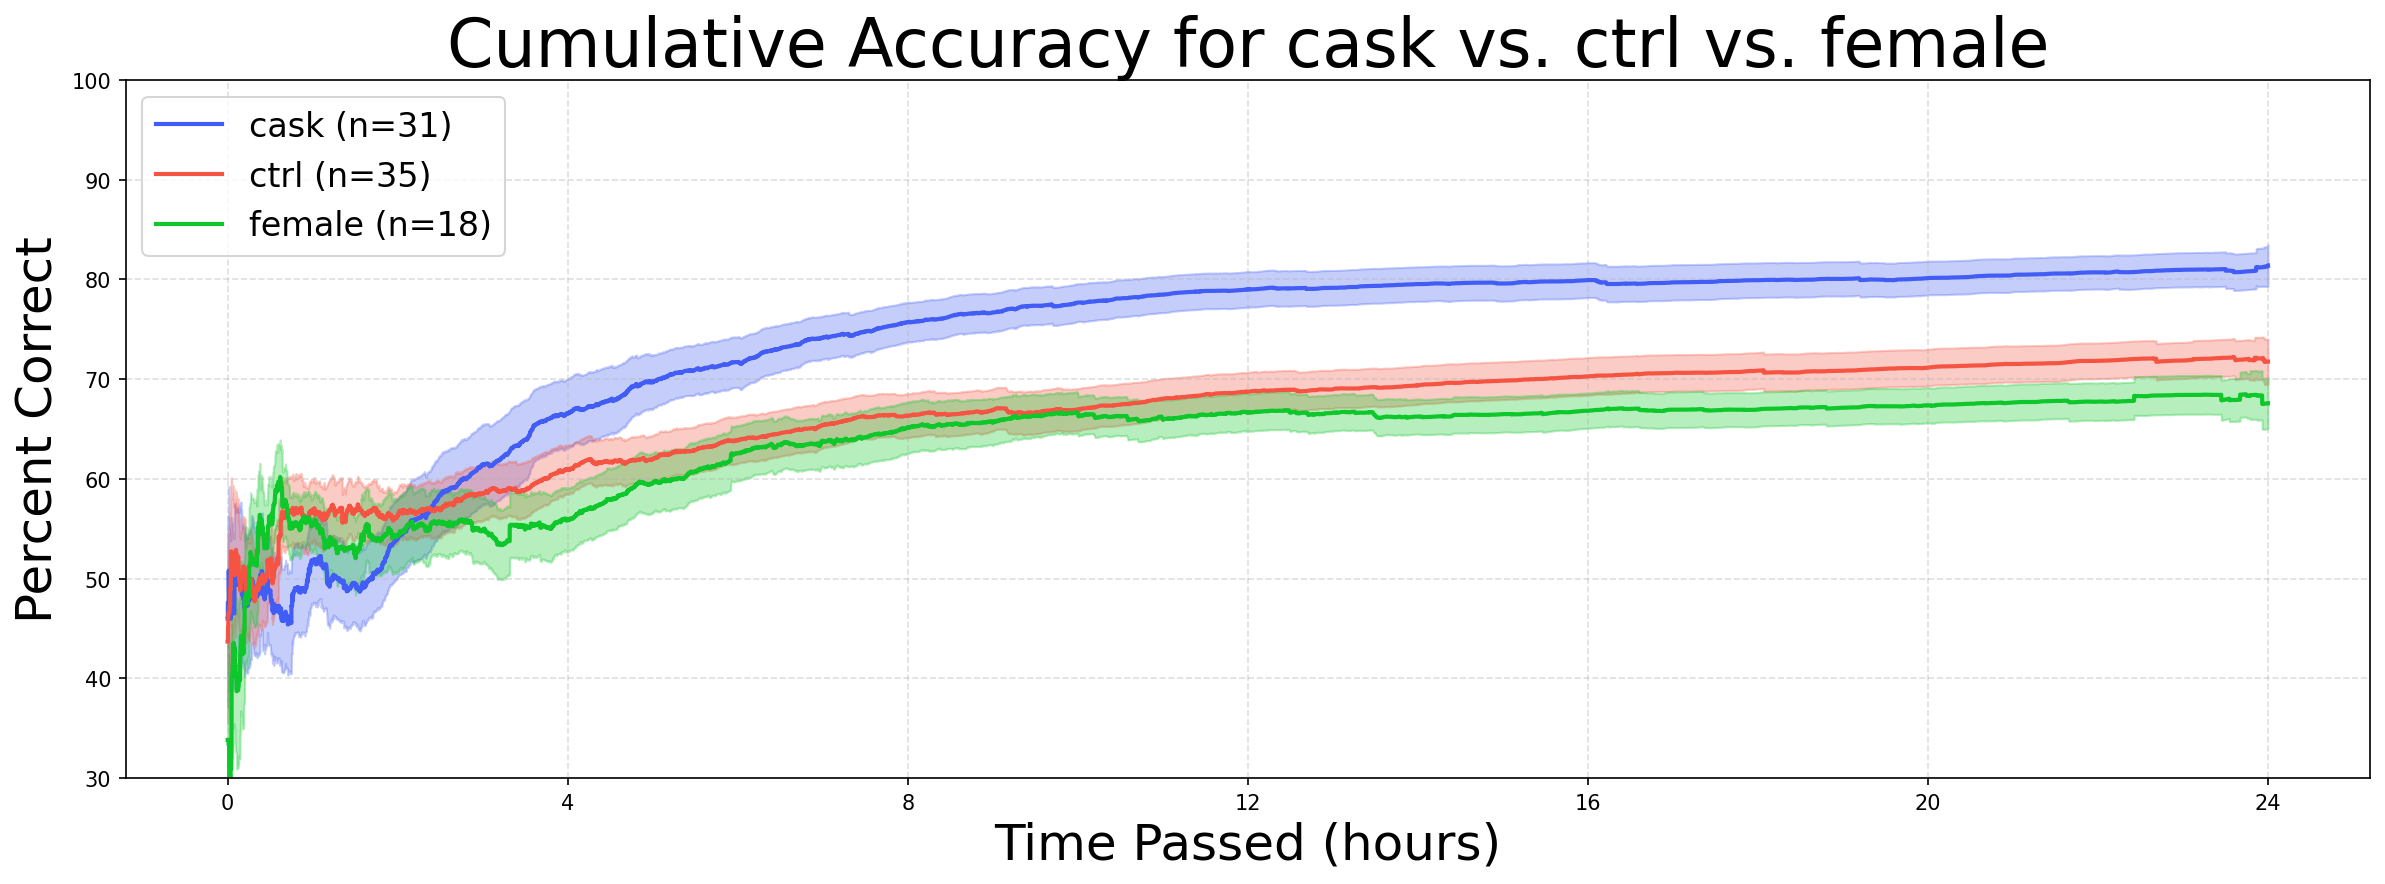

In [4]:
fr1_group_sessions = {
    group: [SESSIONS[sid] for sid in sessions_by_type["FR1"]]
    for group, sessions_by_type in GROUP_SESSIONS.items()
}
fr1_dataframes = {}
fr1_end_accuracy = {}
fr1_learn_time = {}
for group, sessions in fr1_group_sessions.items():
    dfs = []
    ending, learned, sheet_acc = [], [], {}
    for session in sessions:
        df = read_and_record(session, ending, learned, sheet_acc)
        dfs.append(df)
    fr1_dataframes[group] = dfs
    fr1_end_accuracy[group] = ending
    fr1_learn_time[group] = learned

fr1_figure_dir = FIGURE_ROOT / "FR1"
fr1_figure_dir.mkdir(parents=True, exist_ok=True)
labels = list(fr1_dataframes.keys())
plot_cumulative_accuracy(
    [fr1_dataframes[label] for label in labels],
    group_labels=labels,
    bin_size_sec=5,
    export_path=str(fr1_figure_dir / "cumulative_accuracy.svg"),
)

In [5]:
def run_pairwise_tests(metric_map, metric_name, cohort_pairs=None):
    cohort_pairs = cohort_pairs or []
    for g1, g2 in cohort_pairs:
        if g1 not in metric_map or g2 not in metric_map:
            raise KeyError(f"Requested cohorts {g1}, {g2} not found")
        series1, series2 = metric_map[g1], metric_map[g2]
        print(f"[T-test] {metric_name}: {g1} vs {g2}")
        perform_T_test(series1, series2, test_side="two-sided")

def plot_group_stats(metric_map, metric_name, unit, export_filename=None, figure_dir=None, remove_outlier_stds=-1):
    group_names = list(metric_map.keys())
    datasets = [metric_map[name] for name in group_names]
    if export_filename and figure_dir is None:
        raise ValueError("figure_dir must be provided when export_filename is set")
    export_path = str(figure_dir / export_filename) if export_filename else None
    graph_group_stats(
        group_data=datasets,
        stats_name=metric_name,
        unit=unit,
        group_names=group_names,
        export_path=export_path,
        remove_outlier_stds=remove_outlier_stds,
    )

cask Size: 30 	 Average: 82.362 	 SE: 1.457
ctrl Size: 34 	 Average: 73.759 	 SE: 1.558
female Size: 17 	 Average: 68.245 	 SE: 1.800


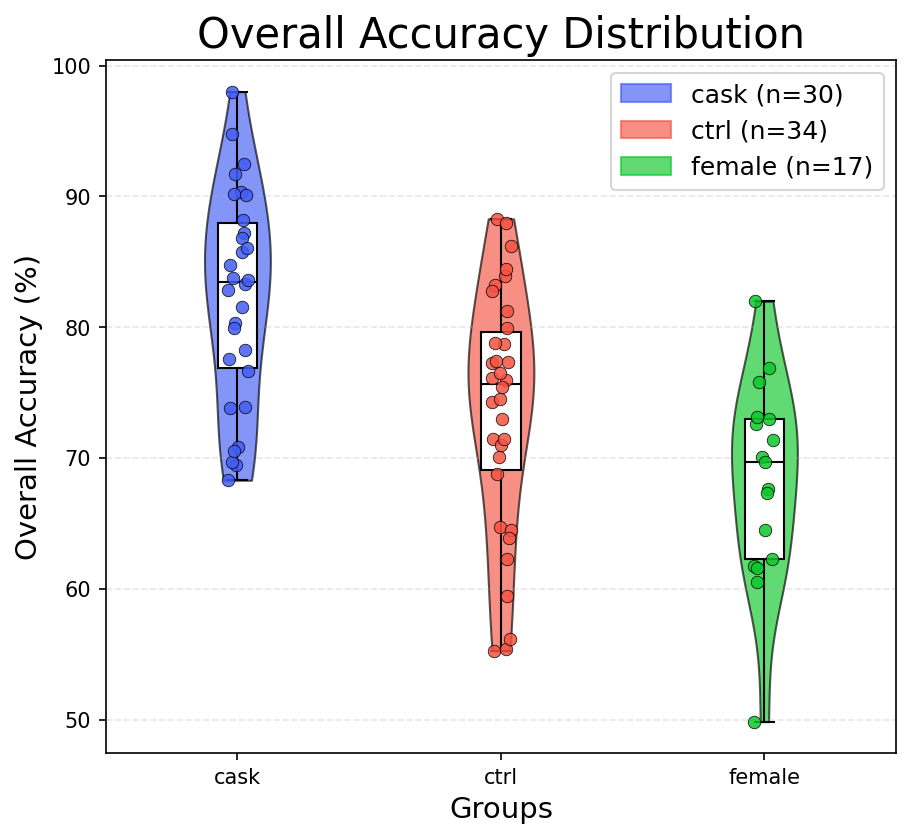

cask Size: 30 	 Average: 1.878 	 SE: 0.265
ctrl Size: 35 	 Average: 4.387 	 SE: 0.620
female Size: 17 	 Average: 4.641 	 SE: 0.573


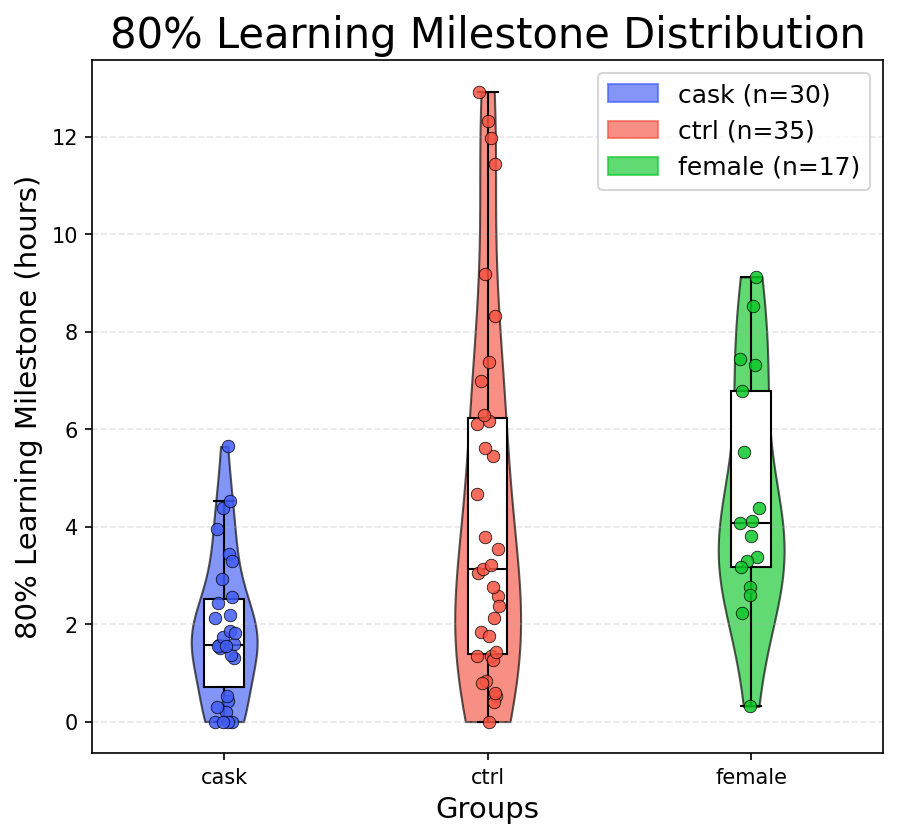

[T-test] Overall Accuracy: cask vs ctrl
P Value is  0.0011517720576340522
[T-test] 80% Learning Milestone: cask vs ctrl
P Value is  0.004973404915244425


In [6]:
plot_group_stats(fr1_end_accuracy, "Overall Accuracy", "%", "overall_accuracy.svg", fr1_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(fr1_learn_time, "80% Learning Milestone", "hours", "learning_milestone_time.svg", fr1_figure_dir, remove_outlier_stds=2.5)

meal_dir = fr1_figure_dir / "meals"
meal_dir.mkdir(parents=True, exist_ok=True)
fr1_meal_metrics = {group: [] for group in labels}
fr1_meal_quality = {group: [] for group in labels}
for group, sessions in fr1_group_sessions.items():
    for session in sessions:
        metrics = process_meal_data(session, export_root=meal_dir)
        fr1_meal_metrics[group].append(metrics)
        fr1_meal_quality[group].append({
            'good_mask': metrics.get('good_mask'),
            'total_meals': metrics.get('total_meals'),
        })

def collect_metric(metric_name, mapping):
    return {
        group: [entry[metric_name] for entry in metrics]
        for group, metrics in mapping.items()
    }

def collect_good_meal_ratio(quality_map):
    ratios = {}
    for group, entries in quality_map.items():
        ratios[group] = []
        for entry in entries:
            good_mask = entry.get('good_mask')
            total_meals = entry.get('total_meals') or (len(good_mask) if good_mask is not None else 0)
            if good_mask is None or total_meals == 0:
                ratios[group].append(0.0)
            else:
                ratios[group].append(float(good_mask.sum()) / total_meals)
    return ratios

avg_pellet = collect_metric("avg_pellet", fr1_meal_metrics)
first_meal_time = collect_metric("fir_meal", fr1_meal_metrics)
first_good_meal_time = collect_metric("fir_good_meal", fr1_meal_metrics)
in_meal_ratio = collect_metric("in_meal_ratio", fr1_meal_metrics)
fr1_good_meal_ratio = collect_good_meal_ratio(fr1_meal_quality)

good_meal_ratio_summary = {
    group: {
        'mean': float(np.mean(values)) if values else 0.0,
        'std': float(np.std(values)) if values else 0.0,
    }
    for group, values in fr1_good_meal_ratio.items()
}

run_pairwise_tests(fr1_end_accuracy, "Overall Accuracy", TEST_PAIRS)
run_pairwise_tests(fr1_learn_time, "80% Learning Milestone", TEST_PAIRS)


cask Size: 30 	 Average: 247.340 	 SE: 6.596
ctrl Size: 34 	 Average: 232.428 	 SE: 5.072
female Size: 17 	 Average: 209.301 	 SE: 8.302


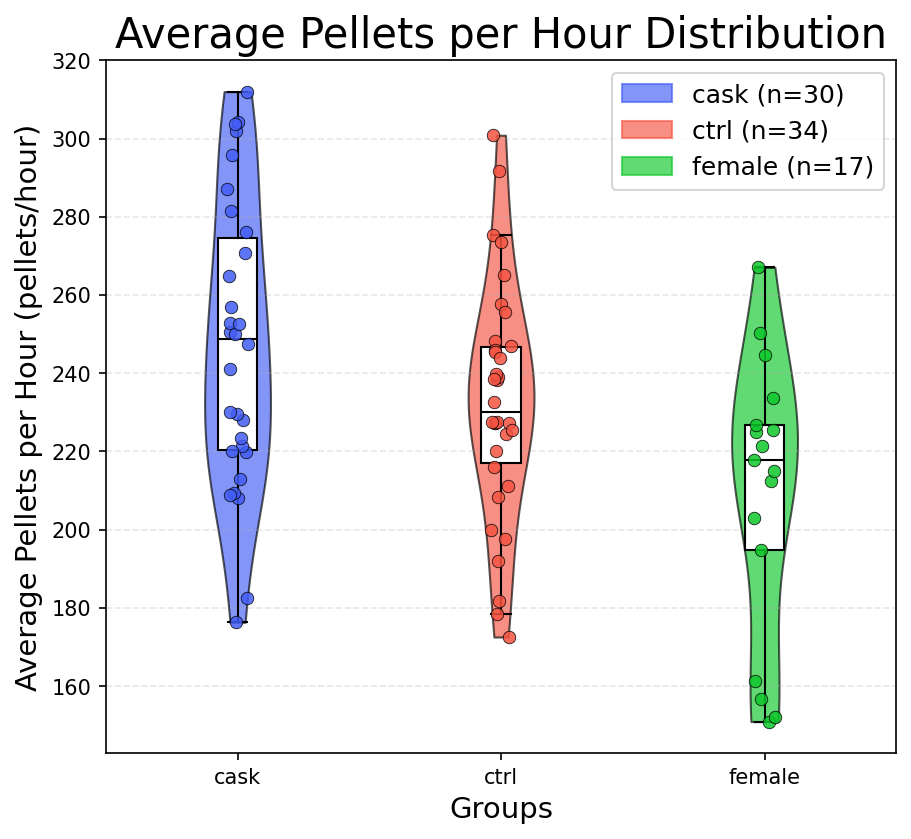

cask Size: 30 	 Average: 1.859 	 SE: 0.207
ctrl Size: 34 	 Average: 2.064 	 SE: 0.153
female Size: 18 	 Average: 2.070 	 SE: 0.269


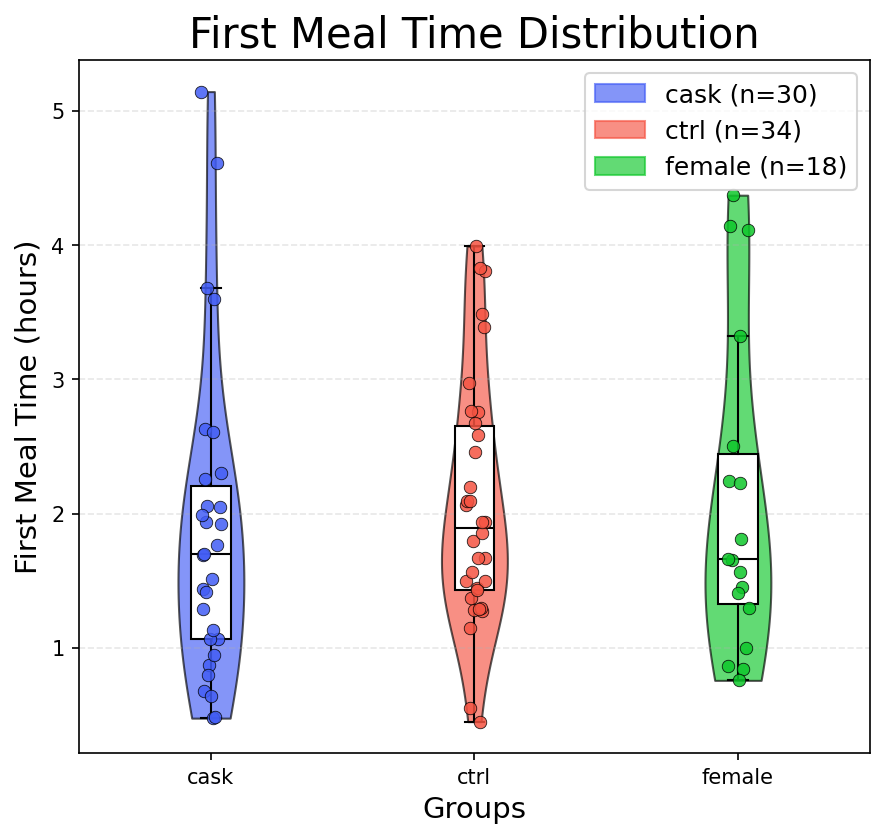

cask Size: 30 	 Average: 2.756 	 SE: 0.248
ctrl Size: 34 	 Average: 2.791 	 SE: 0.204
female Size: 17 	 Average: 2.951 	 SE: 0.288


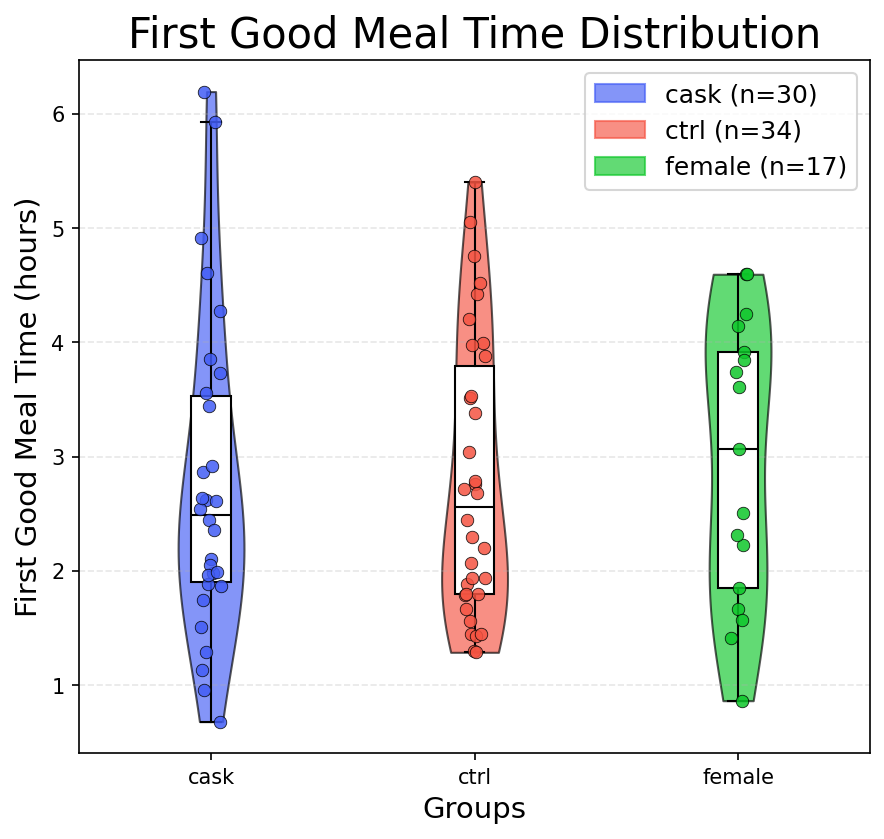

cask Size: 30 	 Average: 0.764 	 SE: 0.012
ctrl Size: 34 	 Average: 0.726 	 SE: 0.011
female Size: 18 	 Average: 0.603 	 SE: 0.020


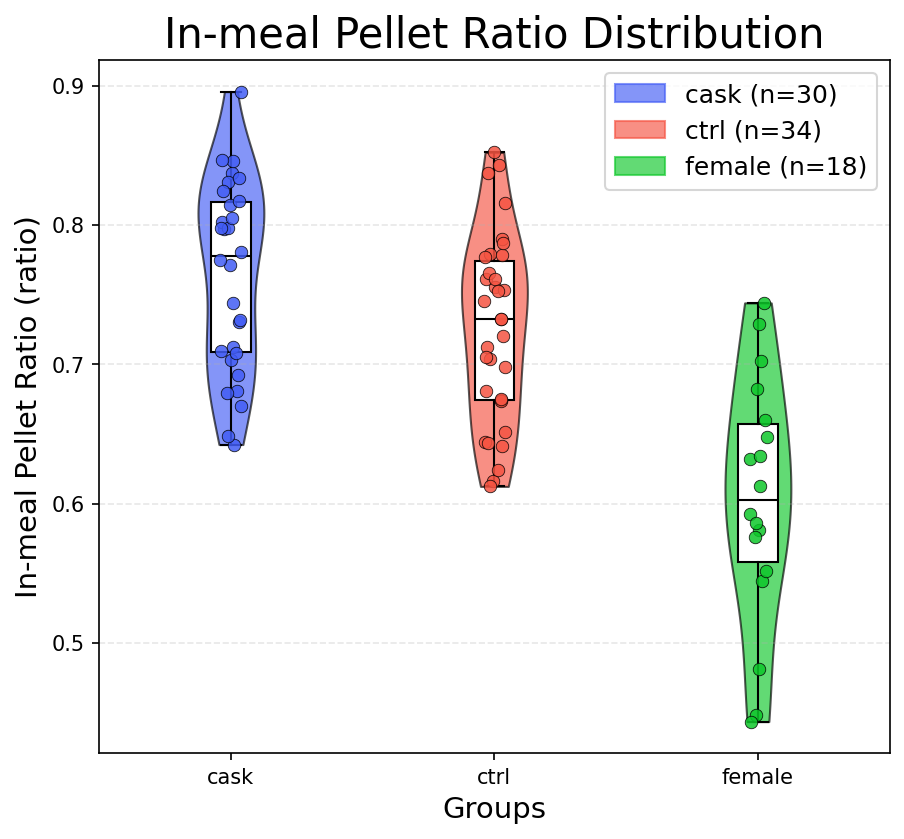

cask Size: 31 	 Average: 0.547 	 SE: 0.028
ctrl Size: 35 	 Average: 0.612 	 SE: 0.023
female Size: 18 	 Average: 0.532 	 SE: 0.032


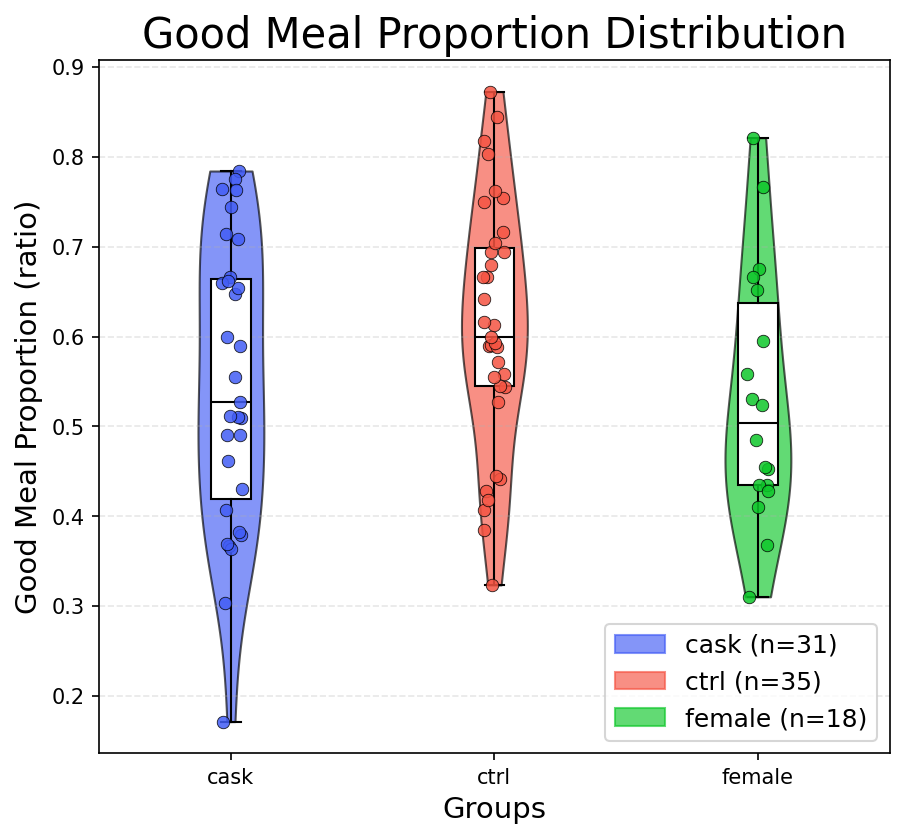

[T-test] Average Pellets per Hour: cask vs ctrl
P Value is  0.09950914475032482
[T-test] First Meal Time: cask vs ctrl
P Value is  0.5705909288272619
[T-test] First Good Meal Time: cask vs ctrl
P Value is  0.8934574260704268
[T-test] In-meal Pellet Ratio: cask vs ctrl
P Value is  0.07874060031326241
[T-test] Good Meal Proportion: cask vs ctrl
P Value is  0.08302349396552032


In [7]:
plot_group_stats(
    avg_pellet,
    "Average Pellets per Hour",
    "pellets/hour",
    "avg_pellets.svg",
    fr1_figure_dir,
    remove_outlier_stds=2.5
)
plot_group_stats(
    first_meal_time,
    "First Meal Time",
    "hours",
    "first_meal_time.svg",
    fr1_figure_dir,
    remove_outlier_stds=2.5
)
plot_group_stats(
    first_good_meal_time,
    "First Good Meal Time",
    "hours",
    "first_good_meal_time.svg",
    fr1_figure_dir,
    remove_outlier_stds=2.5
)
plot_group_stats(
    in_meal_ratio,
    "In-meal Pellet Ratio",
    "ratio",
    "in_meal_ratio.svg",
    fr1_figure_dir,
    remove_outlier_stds=2.5
)
plot_group_stats(
    fr1_good_meal_ratio,
    "Good Meal Proportion",
    "ratio",
    "good_meal_ratio.svg",
    fr1_figure_dir,
    remove_outlier_stds=2.5
)

run_pairwise_tests(avg_pellet, "Average Pellets per Hour", TEST_PAIRS)
run_pairwise_tests(first_meal_time, "First Meal Time", TEST_PAIRS)
run_pairwise_tests(first_good_meal_time, "First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(in_meal_ratio, "In-meal Pellet Ratio", TEST_PAIRS)
run_pairwise_tests(fr1_good_meal_ratio, "Good Meal Proportion", TEST_PAIRS)


In [8]:
rev_figure_dir = FIGURE_ROOT / "REV"
rev_figure_dir.mkdir(parents=True, exist_ok=True)

REV_DAY_LIMIT = 3
REV_MEAL_CONFIG = (60, 2)

rev_group_sessions = {
    group: [SESSIONS[sid] for sid in sessions_by_type.get("REV", [])]
    for group, sessions_by_type in GROUP_SESSIONS.items()
}
rev_group_sessions = {g: s for g, s in rev_group_sessions.items() if s}

In [9]:
rev_transition_metrics = {
    "num_blocks": {g: [] for g in rev_group_sessions},
    "first_good_time": {g: [] for g in rev_group_sessions},
    "first_ratio": {g: [] for g in rev_group_sessions},
    "meal_accuracy": {g: [] for g in rev_group_sessions},
}

rev_transition_exports = []
transition_dir = rev_figure_dir / "transition"
transition_dir.mkdir(parents=True, exist_ok=True)

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        data = session.raw.copy()
        blocks = split_data_to_blocks(data, day=REV_DAY_LIMIT)
        if not blocks:
            continue

        stats = get_transition_info(blocks, list(REV_MEAL_CONFIG), reverse=False)
        ratio, _, good_time = first_meal_stats(stats, ignore_inactive=True)

        rev_transition_metrics["num_blocks"][group].append(len(blocks))
        rev_transition_metrics["first_good_time"][group].append(float(good_time))
        rev_transition_metrics["first_ratio"][group].append(float(ratio))

        meal_acc = []
        for block in blocks:
            _, block_acc = find_meals_paper(
                block,
                time_threshold=REV_MEAL_CONFIG[0],
                pellet_threshold=REV_MEAL_CONFIG[1],
            )
            meal_acc.extend(block_acc)

        if meal_acc:
            rev_transition_metrics["meal_accuracy"][group].append(float(np.mean(meal_acc)))

        export_path = transition_dir / f"{group.lower()}_{session.key.session_id}_transition.svg"
        plot_transition_stats(
            stats,
            blocks,
            mouse_label=session.key.mouse_id,
            group_label=group,
            export_path=export_path,
            show=False,
        )
        rev_transition_exports.append(export_path)

cask Size: 24 	 Average: 27.542 	 SE: 0.705
ctrl Size: 26 	 Average: 23.692 	 SE: 0.580
female Size: 19 	 Average: 22.579 	 SE: 0.738


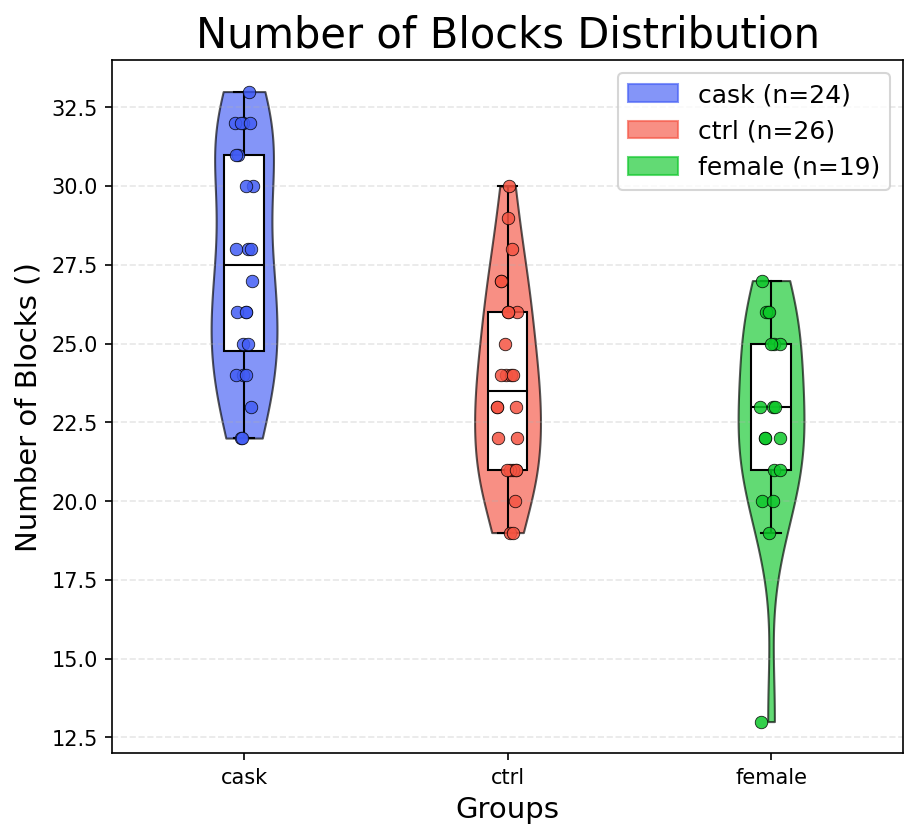

cask Size: 24 	 Average: 51.416 	 SE: 4.389
ctrl Size: 27 	 Average: 55.443 	 SE: 4.844
female Size: 19 	 Average: 75.782 	 SE: 3.541


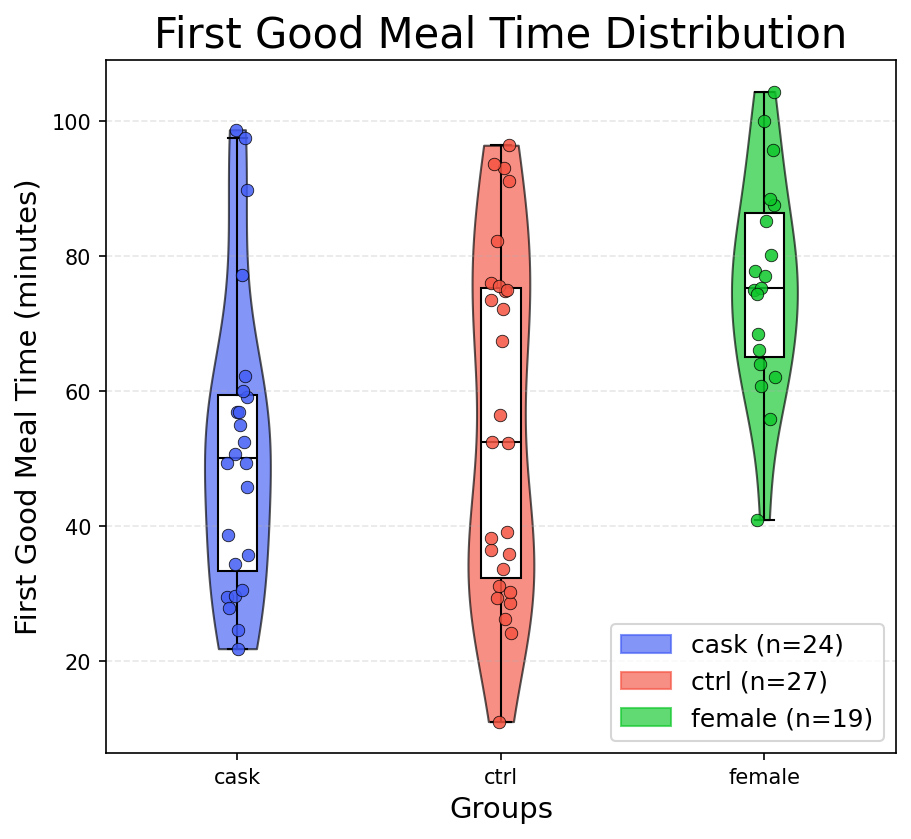

cask Size: 24 	 Average: 0.523 	 SE: 0.019
ctrl Size: 27 	 Average: 0.444 	 SE: 0.018
female Size: 19 	 Average: 0.600 	 SE: 0.019


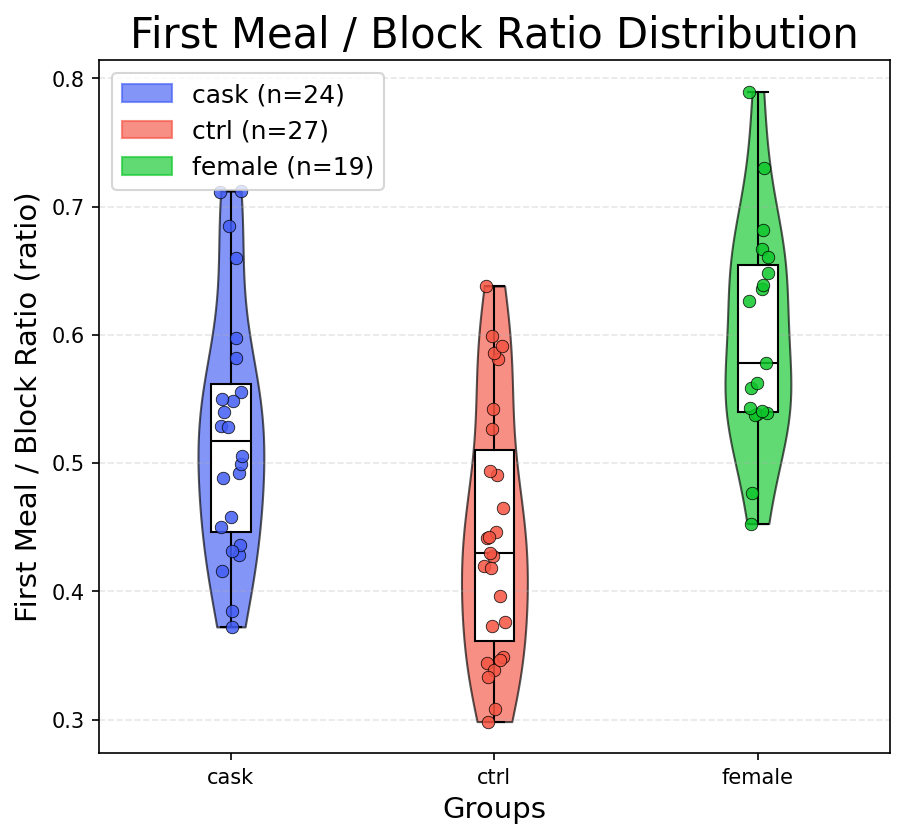

cask Size: 24 	 Average: 85.265 	 SE: 0.837
ctrl Size: 27 	 Average: 87.124 	 SE: 0.511
female Size: 20 	 Average: 85.825 	 SE: 0.638


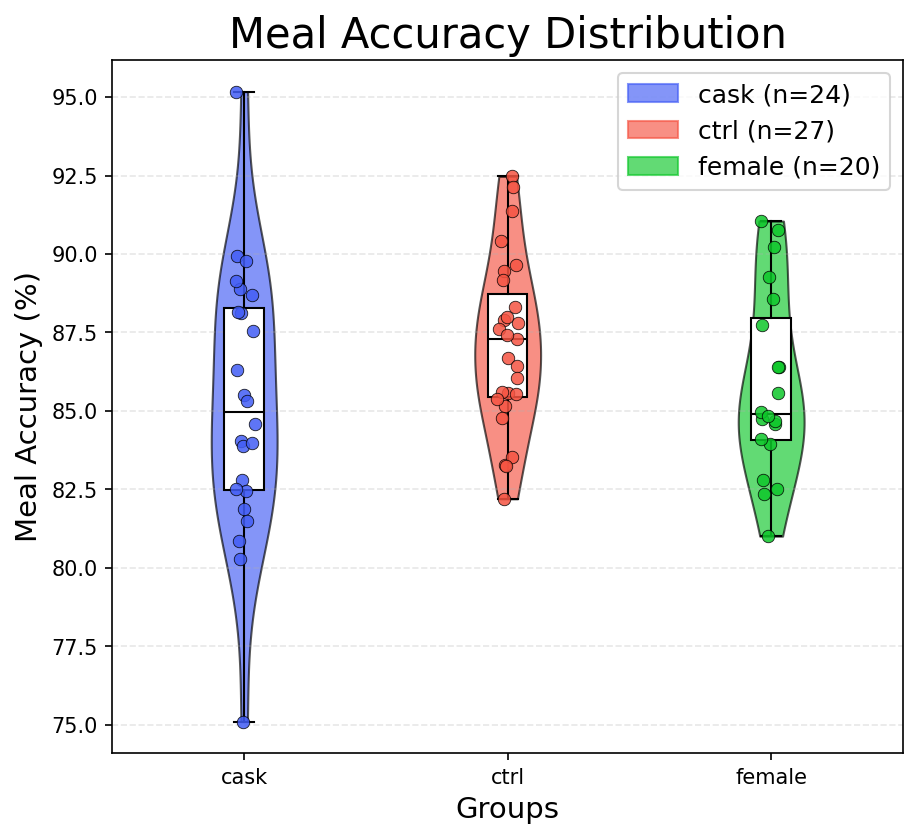

[T-test] Number of Blocks: cask vs ctrl
P Value is  0.03558858874574112
[T-test] First Good Meal Time: cask vs ctrl
P Value is  0.5524107079905747
[T-test] First Meal / Block Ratio: cask vs ctrl
P Value is  0.00595669496758611
[T-test] Meal Accuracy: cask vs ctrl
P Value is  0.06286265554075383


In [10]:
plot_group_stats(rev_transition_metrics["num_blocks"], "Number of Blocks", "", "rev_number_of_blocks.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_transition_metrics["first_good_time"], "First Good Meal Time", "minutes", "rev_first_good_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_transition_metrics["first_ratio"], "First Meal / Block Ratio", "ratio", "rev_first_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_transition_metrics["meal_accuracy"], "Meal Accuracy", "%", "rev_meal_accuracy.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_transition_metrics["num_blocks"], "Number of Blocks", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["first_good_time"], "First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["first_ratio"], "First Meal / Block Ratio", TEST_PAIRS)
run_pairwise_tests(rev_transition_metrics["meal_accuracy"], "Meal Accuracy", TEST_PAIRS)

In [11]:
rev_blocks = {g: [] for g in rev_group_sessions}
rev_learning_scores = {g: [] for g in rev_group_sessions}
rev_learning_results = {g: [] for g in rev_group_sessions}

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        blocks = split_data_to_blocks(session.raw.copy(), day=REV_DAY_LIMIT)
        if not blocks:
            continue
        rev_blocks[group].append(blocks)

        score = learning_score(blocks, block_prop=1.0, action_prop=0.75)
        result = learning_result(blocks, action_prop=0.75)

        rev_learning_scores[group].append(float(score))
        rev_learning_results[group].append(float(result))

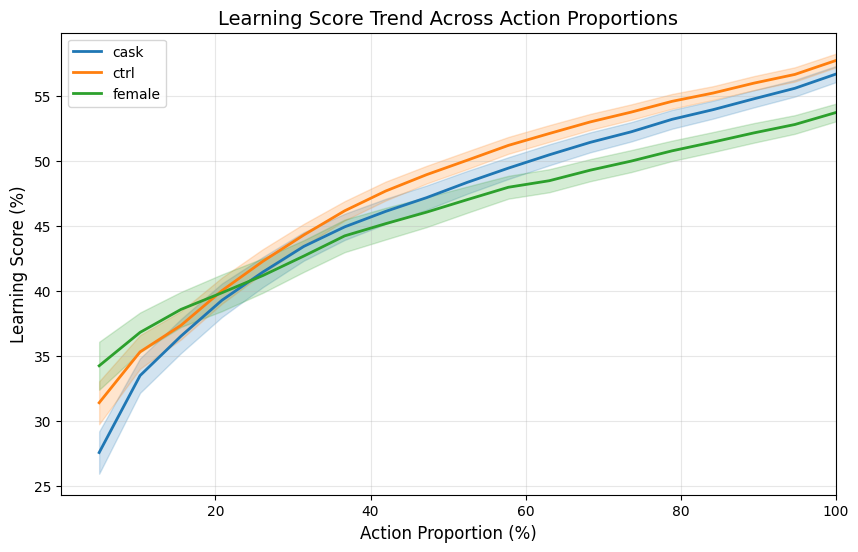

cask Size: 23 	 Average: 73.581 	 SE: 0.753
ctrl Size: 27 	 Average: 72.431 	 SE: 0.733
female Size: 20 	 Average: 67.386 	 SE: 1.102


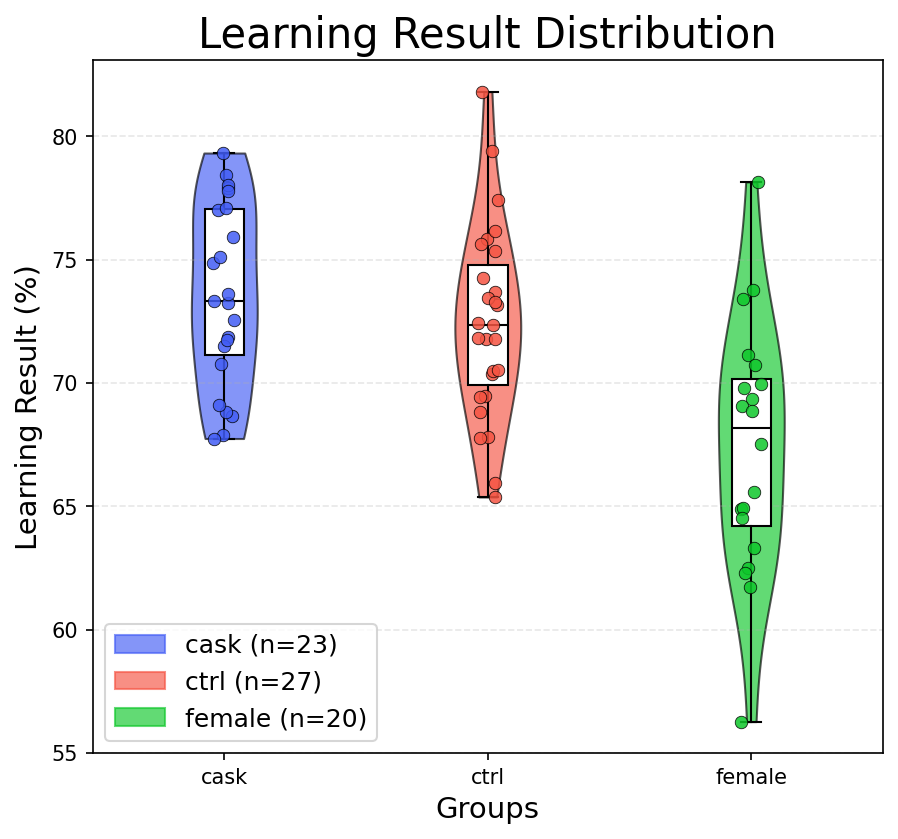

cask Size: 24 	 Average: 0.898 	 SE: 0.007
ctrl Size: 27 	 Average: 0.836 	 SE: 0.008
female Size: 20 	 Average: 0.785 	 SE: 0.016


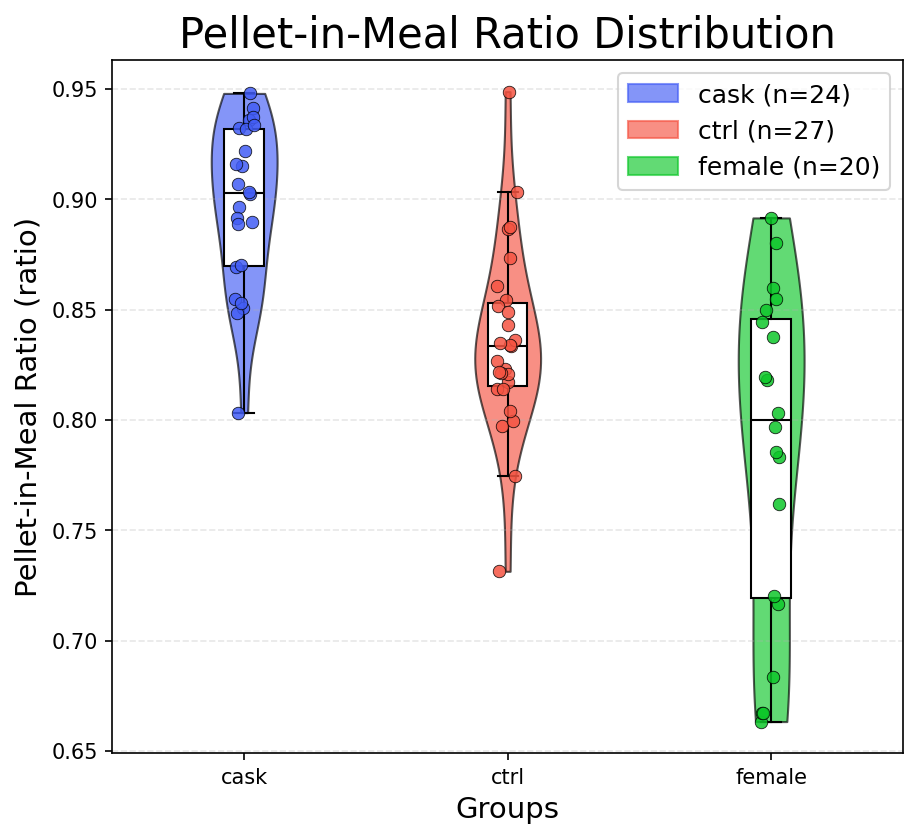

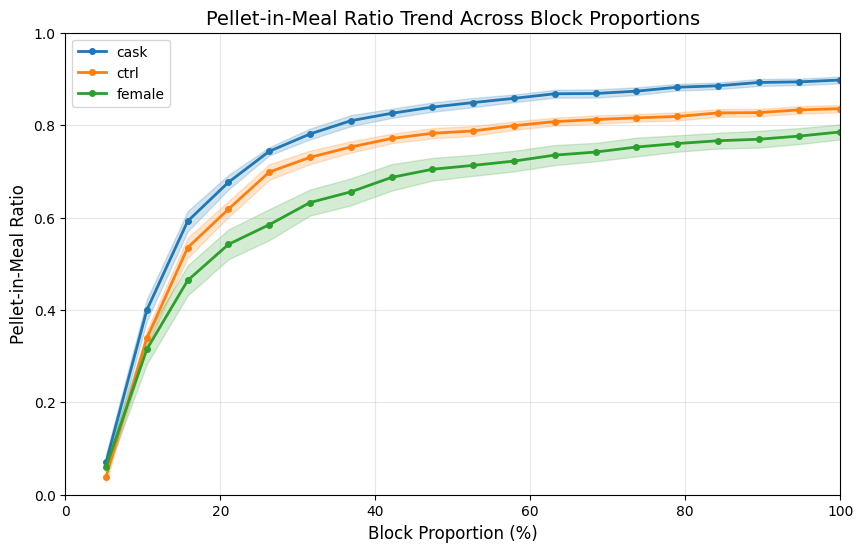

[T-test] Learning Score: cask vs ctrl
P Value is  0.1256352998407167
[T-test] Learning Result: cask vs ctrl
P Value is  0.6105351869784545


In [12]:
plot_learning_score_trend(
    blocks_groups=[rev_blocks[g] for g in GROUPS],
    group_labels=GROUPS,
    block_prop=1.0,
    action_prop=0.75,
    export_path=str(rev_figure_dir / "rev_learning_score_overall.svg"),
)
plot_group_stats(rev_learning_results, "Learning Result", "%", "rev_learning_result.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_pellet_ratio_trend(
    blocks_groups=[rev_blocks[g] for g in GROUPS],
    group_labels=GROUPS,
    export_path=str(rev_figure_dir / "rev_pellet_ratio_overall.svg"),
)

run_pairwise_tests(rev_learning_scores, "Learning Score", TEST_PAIRS)
run_pairwise_tests(rev_learning_results, "Learning Result", TEST_PAIRS)

In [13]:
def block_retrieval_summary(blocks, n_stds=3):
    block_means = []
    for block in blocks:
        times = pd.to_numeric(block["collect_time"], errors="coerce")
        times = times[(times > 0) & times.notna()]
        if times.empty:
            continue
        mean = times.mean()
        std = times.std(ddof=0)
        if not np.isnan(std) and std > 0:
            cutoff = mean + n_stds * std
            times = times[times <= cutoff]
        if not times.empty:
            block_means.append(times.mean())

    if not block_means:
        return [], 0.0, 0.0

    x = np.arange(len(block_means))
    if len(block_means) > 1:
        slope, intercept = np.polyfit(x, block_means, 1)
        pred = slope * len(block_means) + intercept
    else:
        slope = 0.0
        pred = block_means[-1]
    return block_means, float(pred), float(slope)


def plot_retrieval_time_by_block(block_means, *, mouse_label, group_label=None, export_path=None, show=False):
    if not block_means:
        return

    block_indices = np.arange(len(block_means))
    slope, intercept = np.polyfit(block_indices, block_means, 1)
    fit_line = slope * block_indices + intercept

    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
    ax.plot(block_indices + 1, block_means, marker='*', color='#1f77b4', linewidth=2, label='Mean retrieval time')
    ax.plot(block_indices + 1, fit_line, color='#ff7f0e', linestyle='--', linewidth=2, label=f'Best fit (slope={slope:.2f})')

    ax.set_xlabel('Block index', fontsize=12)
    ax.set_ylabel('Mean retrieval time (minutes)', fontsize=12)
    title_parts = ['Retrieval time per block']
    if group_label:
        title_parts.append(f"Group {group_label}")
    title_parts.append(f"Mouse {mouse_label}")
    ax.set_title(' - '.join(title_parts), fontsize=16)
    ax.grid(alpha=0.3)
    ax.legend()

    if export_path:
        fig.savefig(export_path, bbox_inches='tight')

    if show:
        plt.show()
    else:
        plt.close(fig)

In [14]:
rev_retrieval_mean = {g: [] for g in rev_group_sessions}
rev_retrieval_pred = {g: [] for g in rev_group_sessions}
rev_retrieval_slope = {g: [] for g in rev_group_sessions}

retrieval_dir = rev_figure_dir / "retrieval"
retrieval_dir.mkdir(parents=True, exist_ok=True)

for group, sessions in rev_group_sessions.items():
    for session in sessions:
        blocks = split_data_to_blocks(session.raw.copy(), day=REV_DAY_LIMIT)
        block_means, pred, slope = block_retrieval_summary(blocks)
        if not block_means:
            continue
        rev_retrieval_mean[group].append(float(np.mean(block_means)))
        rev_retrieval_pred[group].append(pred)
        rev_retrieval_slope[group].append(slope)

        export_path = retrieval_dir / f"{group.lower()}_{session.key.session_id}_retrieval.svg"
        plot_retrieval_time_by_block(
            block_means,
            mouse_label=session.key.mouse_id,
            group_label=group,
            export_path=export_path,
            show=False,
        )

cask Size: 24 	 Average: 2.556 	 SE: 0.276
ctrl Size: 25 	 Average: 1.851 	 SE: 0.163
female Size: 19 	 Average: 4.174 	 SE: 0.397


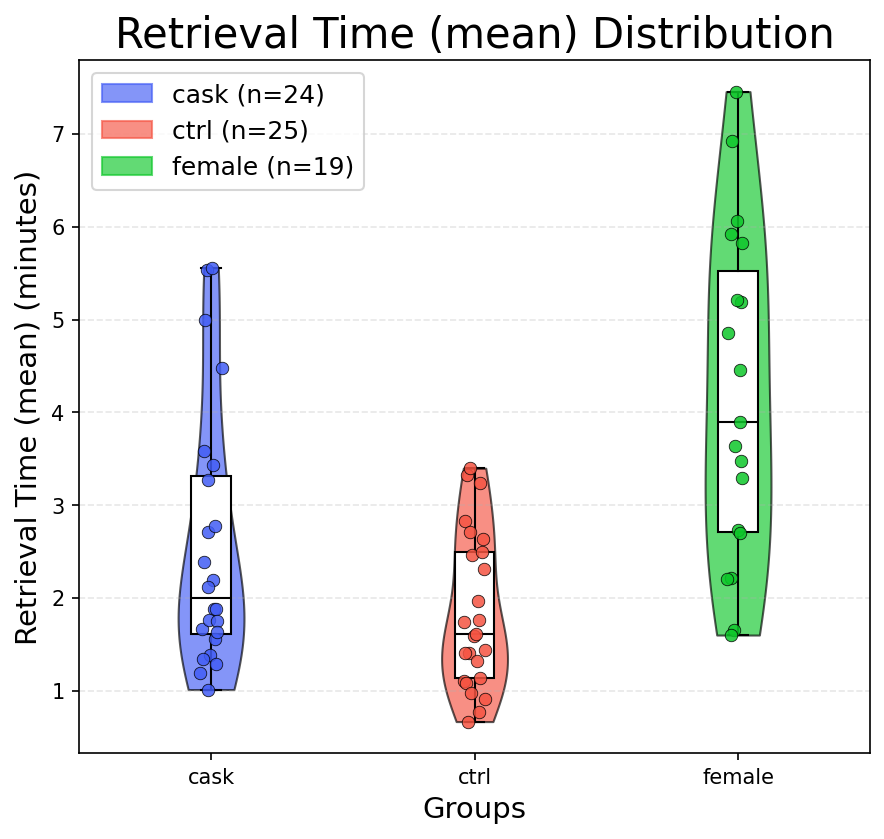

cask Size: 24 	 Average: 2.204 	 SE: 0.406
ctrl Size: 26 	 Average: 1.531 	 SE: 0.337
female Size: 19 	 Average: 2.857 	 SE: 0.681


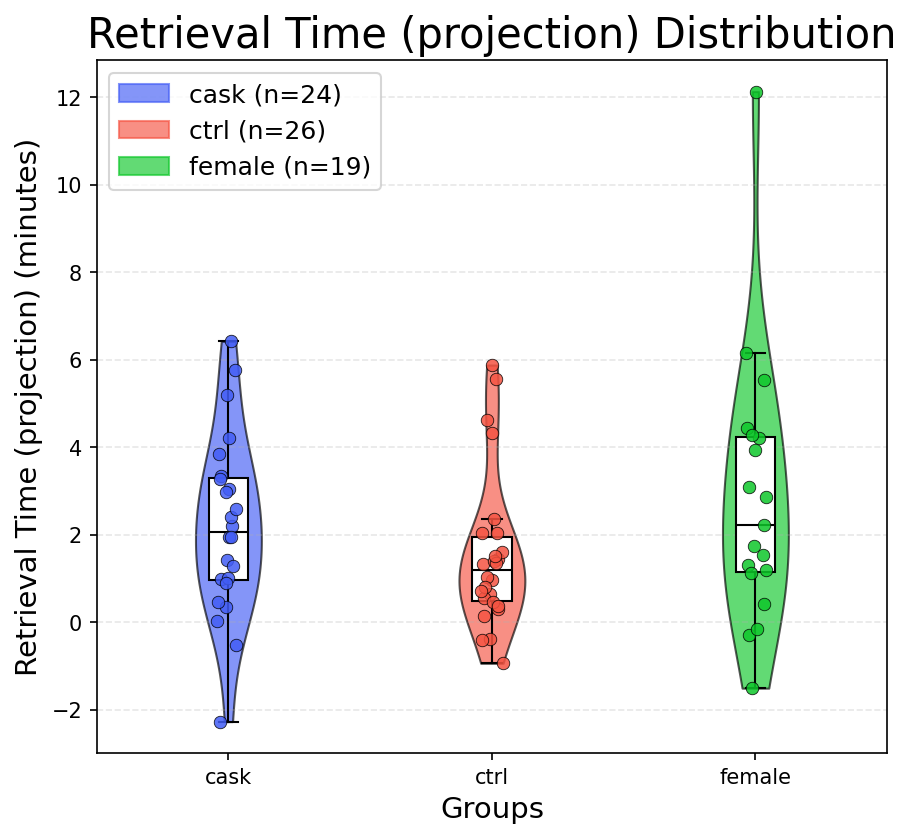

cask Size: 23 	 Average: -0.011 	 SE: 0.020
ctrl Size: 26 	 Average: -0.028 	 SE: 0.022
female Size: 20 	 Average: -0.086 	 SE: 0.064


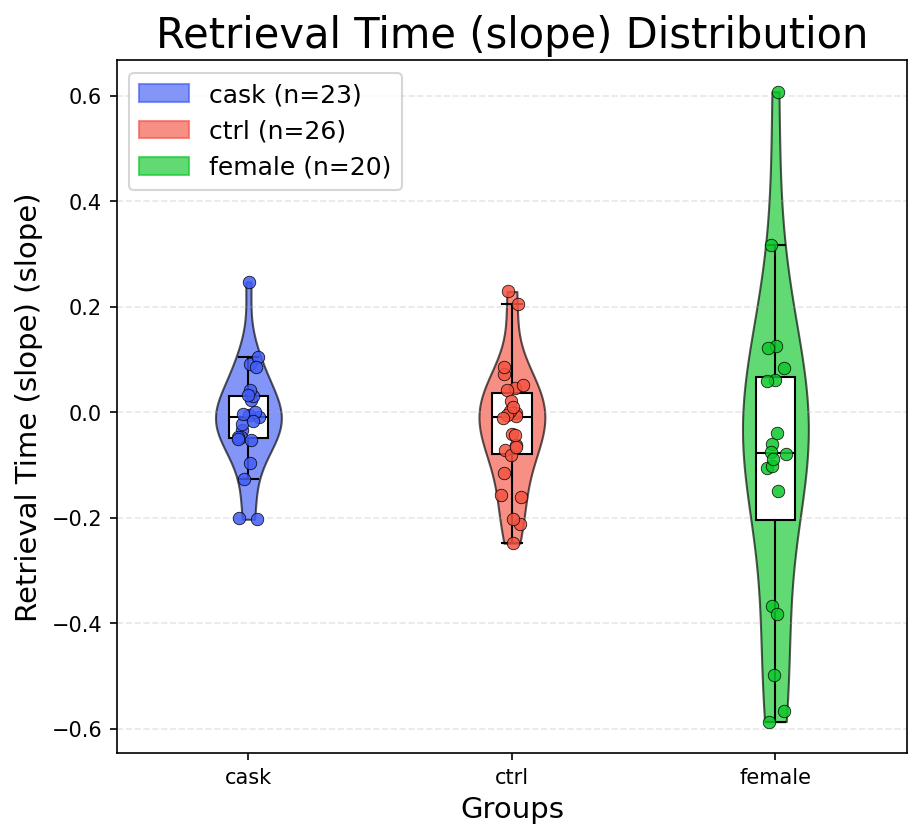

[T-test] Retrieval Time (mean): cask vs ctrl
P Value is  0.45581000180821174
[T-test] Retrieval Time (projection): cask vs ctrl
P Value is  0.4743755381867111
[T-test] Retrieval Time (slope): cask vs ctrl
P Value is  0.6362323907419827


In [15]:
plot_group_stats(rev_retrieval_mean, "Retrieval Time (mean)", "minutes", "rev_retrieval_mean.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_retrieval_pred, "Retrieval Time (projection)", "minutes", "rev_retrieval_projection.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_retrieval_slope, "Retrieval Time (slope)", "slope", "rev_retrieval_slope.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_retrieval_mean, "Retrieval Time (mean)", TEST_PAIRS)
run_pairwise_tests(rev_retrieval_pred, "Retrieval Time (projection)", TEST_PAIRS)
run_pairwise_tests(rev_retrieval_slope, "Retrieval Time (slope)", TEST_PAIRS)

cask Size: 24 	 Average: 225.547 	 SE: 5.475
ctrl Size: 26 	 Average: 193.315 	 SE: 4.177
female Size: 19 	 Average: 188.587 	 SE: 6.435


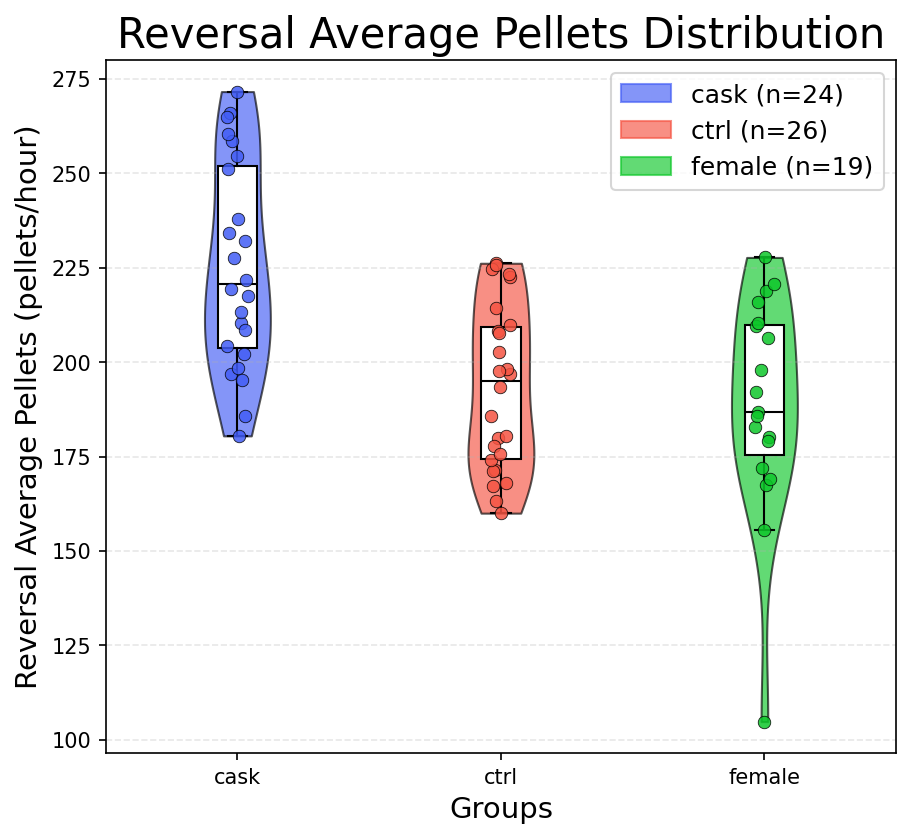

cask Size: 23 	 Average: 1.043 	 SE: 0.153
ctrl Size: 26 	 Average: 0.828 	 SE: 0.118
female Size: 19 	 Average: 1.646 	 SE: 0.213


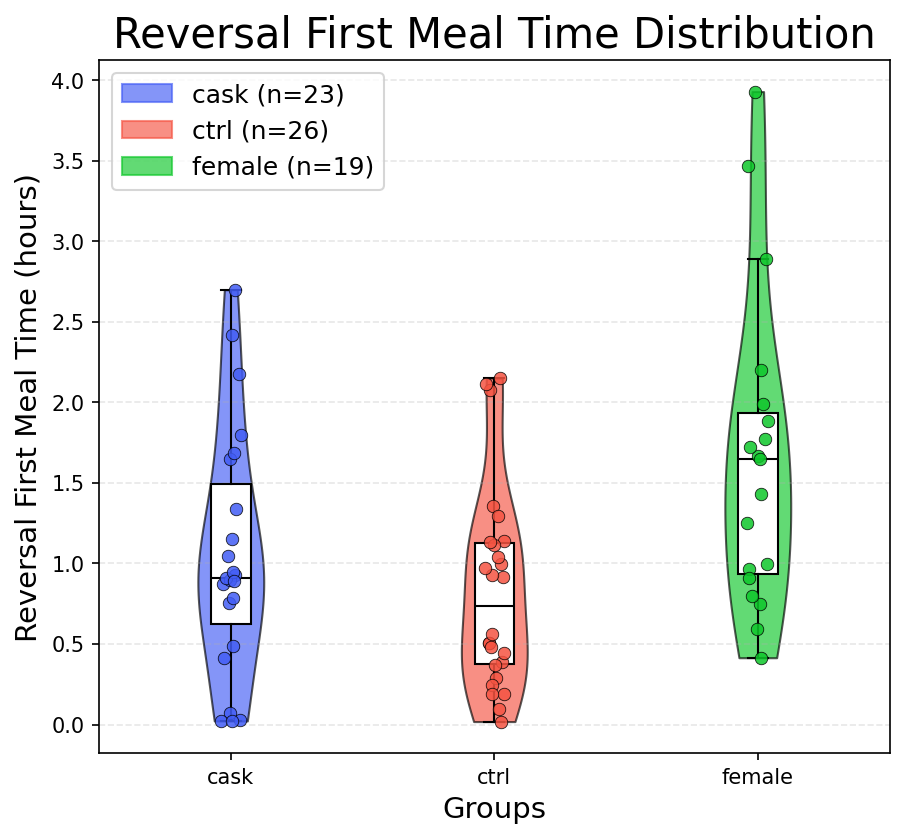

cask Size: 23 	 Average: 1.697 	 SE: 0.231
ctrl Size: 26 	 Average: 1.372 	 SE: 0.201
female Size: 19 	 Average: 2.287 	 SE: 0.224


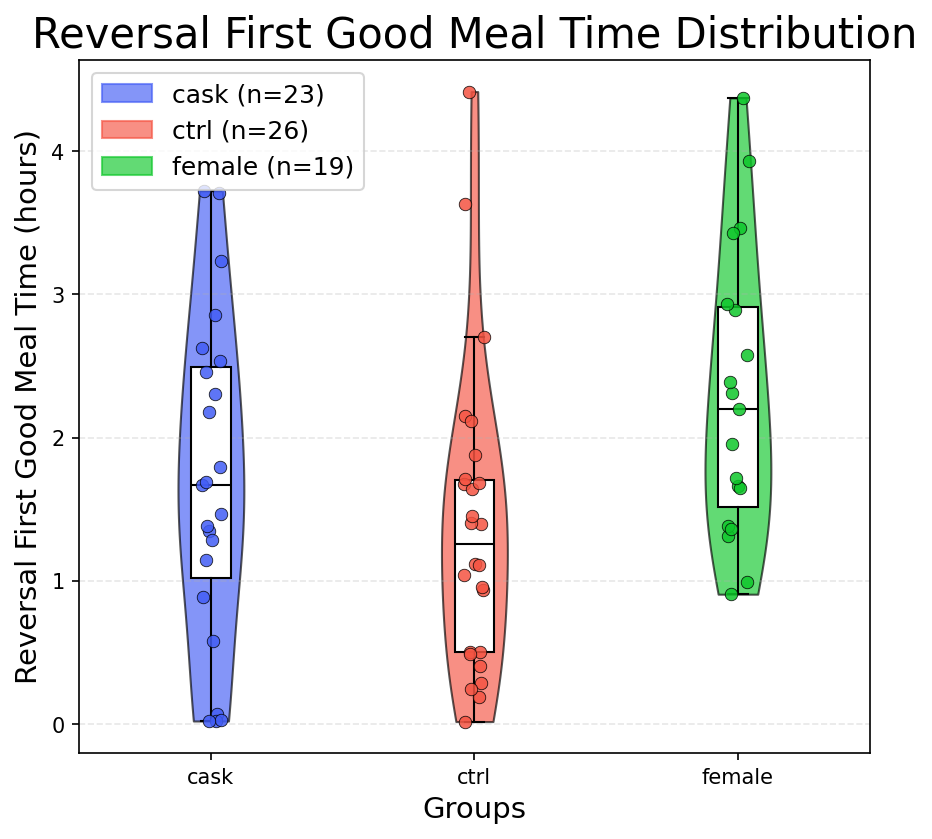

cask Size: 24 	 Average: 0.286 	 SE: 0.010
ctrl Size: 26 	 Average: 0.299 	 SE: 0.017
female Size: 19 	 Average: 0.320 	 SE: 0.019


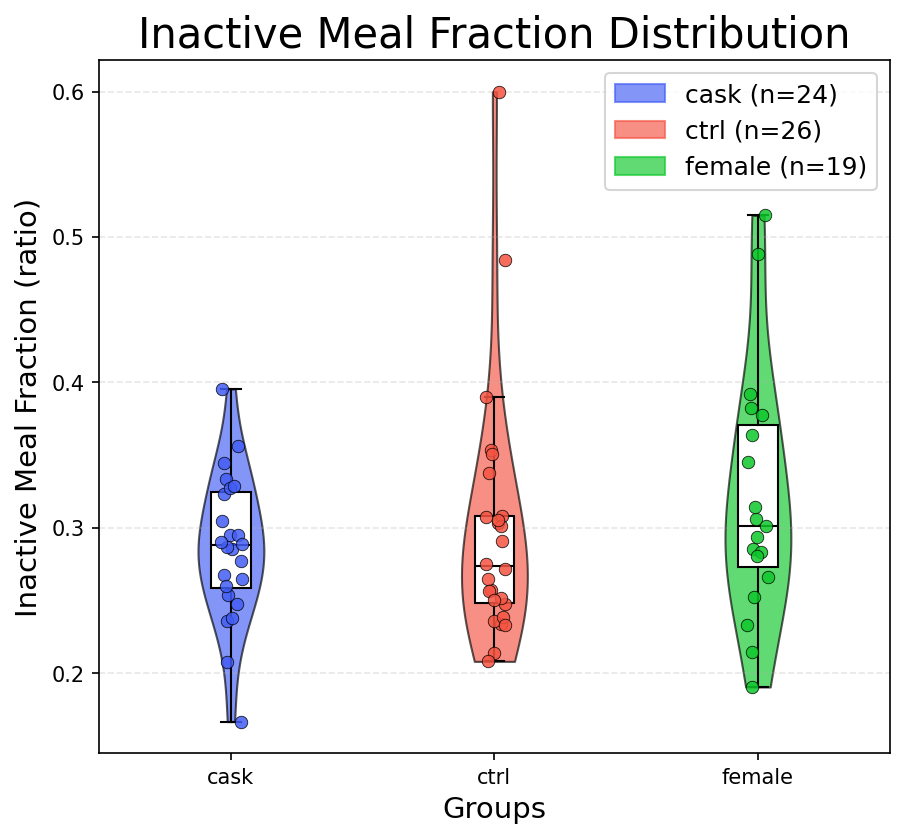

cask Size: 24 	 Average: 0.636 	 SE: 0.014
ctrl Size: 27 	 Average: 0.612 	 SE: 0.012
female Size: 20 	 Average: 0.511 	 SE: 0.012


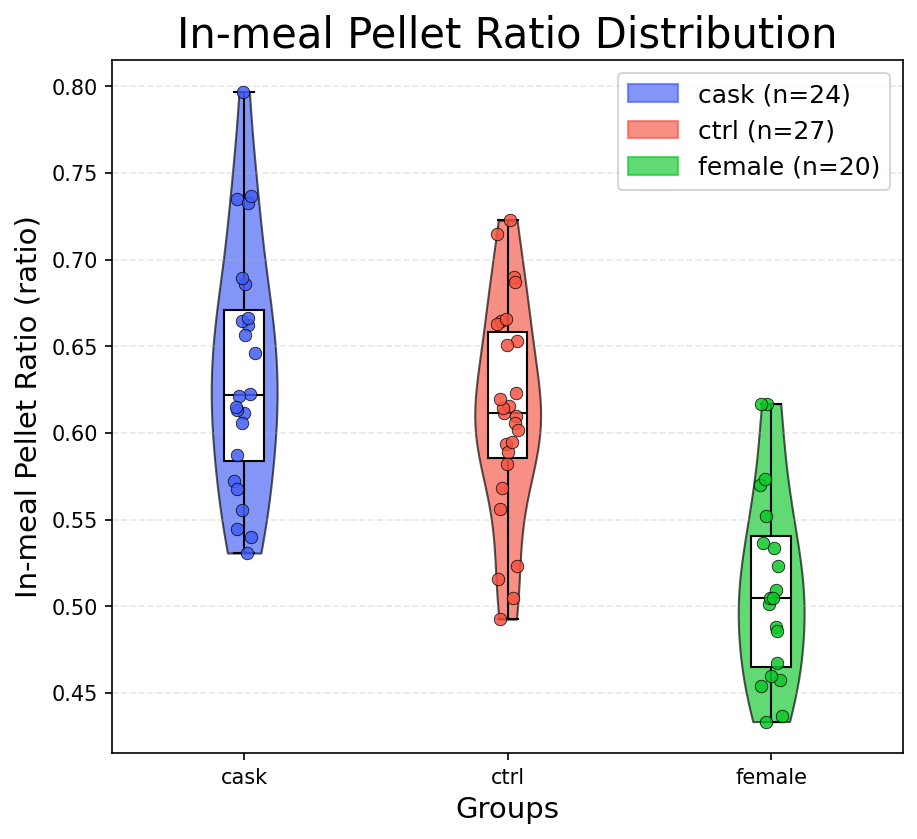

cask Size: 24 	 Average: 0.425 	 SE: 0.031
ctrl Size: 26 	 Average: 0.582 	 SE: 0.019
female Size: 20 	 Average: 0.479 	 SE: 0.022


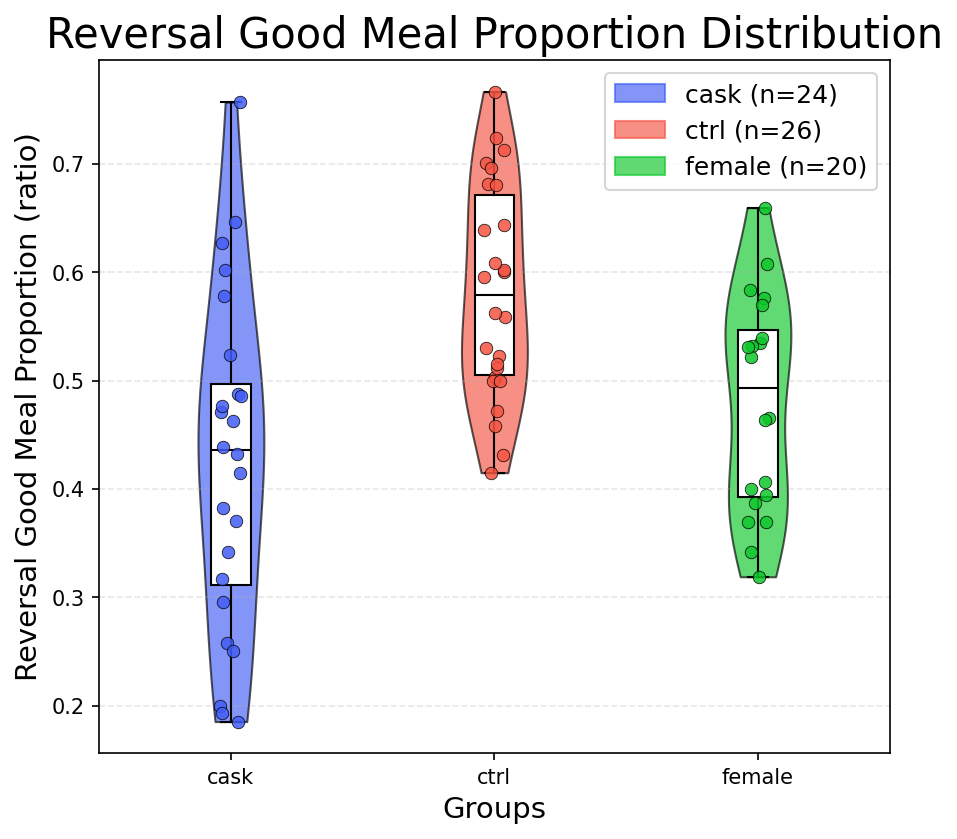

[T-test] Reversal Average Pellets: cask vs ctrl
P Value is  5.185386777569849e-05
[T-test] Reversal First Meal Time: cask vs ctrl
P Value is  0.27288439488456306
[T-test] Reversal First Good Meal Time: cask vs ctrl
P Value is  0.83501656815976
[T-test] Inactive Meal Fraction: cask vs ctrl
P Value is  0.2748433653192888
[T-test] In-meal Pellet Ratio: cask vs ctrl
P Value is  0.2053340995075969
[T-test] Reversal Good Meal Proportion: cask vs ctrl
P Value is  0.0009816640567062145


In [ ]:
rev_meal_dir = rev_figure_dir / "meals"
rev_meal_dir.mkdir(parents=True, exist_ok=True)

rev_meal_metrics = {group: [] for group in rev_group_sessions}
rev_meal_quality = {group: [] for group in rev_group_sessions}
for group, sessions in rev_group_sessions.items():
    for session in sessions:
        metrics = process_meal_data(session, export_root=rev_meal_dir)
        rev_meal_metrics[group].append(metrics)
        rev_meal_quality[group].append({
            'good_mask': metrics.get('good_mask'),
            'total_meals': metrics.get('total_meals'),
        })

rev_avg_pellet = collect_metric("avg_pellet", rev_meal_metrics)
rev_first_meal = collect_metric("fir_meal", rev_meal_metrics)
rev_first_good = collect_metric("fir_good_meal", rev_meal_metrics)
rev_inactive = collect_metric("inactive_meals", rev_meal_metrics)
rev_in_meal_ratio = collect_metric("in_meal_ratio", rev_meal_metrics)
rev_good_meal_ratio = collect_good_meal_ratio(rev_meal_quality)

plot_group_stats(rev_avg_pellet, "Reversal Average Pellets", "pellets/hour", "rev_avg_pellet.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_first_meal, "Reversal First Meal Time", "hours", "rev_first_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_first_good, "Reversal First Good Meal Time", "hours", "rev_first_good_meal_time.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_good_meal_ratio, "Reversal Good Meal Proportion", "ratio", "rev_good_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_inactive, "Inactive Meal Fraction", "ratio", "rev_inactive_meals.svg", rev_figure_dir, remove_outlier_stds=2.5)
plot_group_stats(rev_in_meal_ratio, "In-meal Pellet Ratio", "ratio", "rev_in_meal_ratio.svg", rev_figure_dir, remove_outlier_stds=2.5)

run_pairwise_tests(rev_avg_pellet, "Reversal Average Pellets", TEST_PAIRS)
run_pairwise_tests(rev_first_meal, "Reversal First Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_first_good, "Reversal First Good Meal Time", TEST_PAIRS)
run_pairwise_tests(rev_inactive, "Inactive Meal Fraction", TEST_PAIRS)
run_pairwise_tests(rev_in_meal_ratio, "In-meal Pellet Ratio", TEST_PAIRS)
run_pairwise_tests(rev_good_meal_ratio, "Reversal Good Meal Proportion", TEST_PAIRS)